In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

## LeNet

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
net.eval()
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, f'output shape: \t{X.shape}')

Conv2d output shape: 	torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	torch.Size([1, 6, 14, 14])
Conv2d output shape: 	torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	torch.Size([1, 16, 5, 5])
Flatten output shape: 	torch.Size([1, 400])
Linear output shape: 	torch.Size([1, 120])
Sigmoid output shape: 	torch.Size([1, 120])
Linear output shape: 	torch.Size([1, 84])
Sigmoid output shape: 	torch.Size([1, 84])
Linear output shape: 	torch.Size([1, 10])


## 模型训练

In [4]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集, 然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True
    )
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
    )

In [5]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [6]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [7]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(net.parameters()).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
            

In [9]:
"""example
net = nn.Sequential(
    nn.Linear(2,3),
    nn.Linear(3,1)
)
net.state_dict(), net.parameters(), net.named_parameters(), list(net.parameters()), list(net.named_parameters())
"""
"""output
(OrderedDict([('0.weight',
               tensor([[-0.0716, -0.5472],
                       [ 0.5413, -0.0393],
                       [-0.3345,  0.3950]])),
              ('0.bias', tensor([-0.2480,  0.3593,  0.6091])),
              ('1.weight', tensor([[ 0.1163, -0.1248,  0.3258]])),
              ('1.bias', tensor([-0.1264]))]),
 <generator object Module.parameters at 0x7fb3130cc200>,
 <generator object Module.named_parameters at 0x7fb313236640>,
 [Parameter containing:
  tensor([[-0.0716, -0.5472],
          [ 0.5413, -0.0393],
          [-0.3345,  0.3950]], requires_grad=True),
  Parameter containing:
  tensor([-0.2480,  0.3593,  0.6091], requires_grad=True),
  Parameter containing:
  tensor([[ 0.1163, -0.1248,  0.3258]], requires_grad=True),
  Parameter containing:
  tensor([-0.1264], requires_grad=True)],
 [('0.weight',
   Parameter containing:
   tensor([[-0.0716, -0.5472],
           [ 0.5413, -0.0393],
           [-0.3345,  0.3950]], requires_grad=True)),
  ('0.bias',
   Parameter containing:
   tensor([-0.2480,  0.3593,  0.6091], requires_grad=True)),
  ('1.weight',
   Parameter containing:
   tensor([[ 0.1163, -0.1248,  0.3258]], requires_grad=True)),
  ('1.bias',
   Parameter containing:
   tensor([-0.1264], requires_grad=True))])
"""

"output\n(OrderedDict([('0.weight',\n               tensor([[-0.0716, -0.5472],\n                       [ 0.5413, -0.0393],\n                       [-0.3345,  0.3950]])),\n              ('0.bias', tensor([-0.2480,  0.3593,  0.6091])),\n              ('1.weight', tensor([[ 0.1163, -0.1248,  0.3258]])),\n              ('1.bias', tensor([-0.1264]))]),\n <generator object Module.parameters at 0x7fb3130cc200>,\n <generator object Module.named_parameters at 0x7fb313236640>,\n [Parameter containing:\n  tensor([[-0.0716, -0.5472],\n          [ 0.5413, -0.0393],\n          [-0.3345,  0.3950]], requires_grad=True),\n  Parameter containing:\n  tensor([-0.2480,  0.3593,  0.6091], requires_grad=True),\n  Parameter containing:\n  tensor([[ 0.1163, -0.1248,  0.3258]], requires_grad=True),\n  Parameter containing:\n  tensor([-0.1264], requires_grad=True)],\n [('0.weight',\n   Parameter containing:\n   tensor([[-0.0716, -0.5472],\n           [ 0.5413, -0.0393],\n           [-0.3345,  0.3950]], requires

In [10]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.cumsum(self.times).tolist()

In [11]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """使用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1,num_epochs], 
                        legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_batches//5) == 0 or i == num_batches-1:
                animator.add(epoch+(i+1)/num_batches, (train_l, train_acc, None))
            test_acc = evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.467, train acc 0.822, test acc 0.800
3350.4 examples/sec on cpu


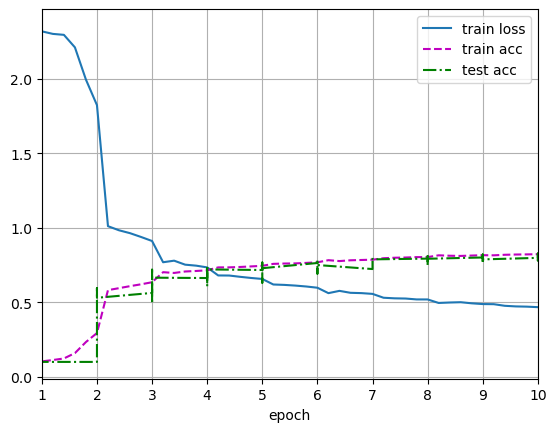

In [13]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))